#                                 Network Anomaly Detection 
###                                                 IDS KDD dataset  would be used

In [71]:
import pandas as pd

In [73]:
#read the dataset 
kdd_dataset = pd.read_csv("kddcup_dataset.csv", index_col=None)

In [75]:
#examine the proportion of types of traffic
y = kdd_dataset["label"].values
from collections import Counter
Counter(y).most_common()

[('normal', 39247),
 ('back', 1098),
 ('apache2', 794),
 ('neptune', 93),
 ('phf', 2),
 ('portsweep', 2),
 ('saint', 1)]

In [77]:
#convert all non-normal observations into a single class:
def categorize_threats(text):
    """Binarize target threats into normal or system_anomaly."""
    if text == "normal":
        return 0
    else:
        return 1
kdd_dataset["label"] = kdd_dataset["label"].apply(categorize_threats)

In [137]:
Counter(kdd_dataset["label"]).most_common()

[(0, 39247), (1, 1990)]

In [79]:
# A ratio of anomalies and normal ... later be used in isolation forest
#the values closer to 1 are considered Anomalous and the values that are <0.5 are considered to be "normal".
y = kdd_dataset["label"].values
counts = Counter(y).most_common()
contamination_parameter = counts[1][1] / (counts[0][1] + counts[1][1])

In [81]:
# need to convert all categorical features into numerical state for easy classification & detection
from sklearn.preprocessing import LabelEncoder

encode_dic = dict()
for i in kdd_dataset.columns:
    if kdd_dataset[i].dtype == "object":
        encode_dic[i] = LabelEncoder()
        kdd_dataset[i] = encode_dic[i].fit_transform(kdd_dataset[i])

In [83]:
#Splitting the dataset into threat and normal state
kdd_dataset_normal = kdd_dataset[kdd_dataset["label"] == 0]
kdd_dataset_abnormal = kdd_dataset[kdd_dataset["label"] == 1]

y_normal_traffic = kdd_dataset_normal.pop("label").values
X_normal_traffic = kdd_dataset_normal.values

y_anomaly_traffic = kdd_dataset_abnormal.pop("label").values
X_anomaly_traffic = kdd_dataset_abnormal.values

In [85]:
#newly categorized dataset with 0=normal & 1=abnormal
Counter(y).most_common()

[(0, 39247), (1, 1990)]

In [87]:
#Plitting the dataset for training and testing
from sklearn.model_selection import train_test_split

X_normal_traffic_train, X_normal_traffic_test, y_normal_traffic_train, y_normal_traffic_test = train_test_split(X_normal_traffic, y_normal_traffic, test_size=0.3, random_state=11)

X_anomaly_traffic_train, X_anomaly_traffic_test, y_anomaly_traffic_train, y_anomaly_traffic_test = train_test_split(X_anomaly_traffic, y_anomaly_traffic, test_size=0.3, random_state=11)

import numpy as np
#training
X_train = np.concatenate((X_normal_traffic_train, X_anomaly_traffic_train))
y_train = np.concatenate((y_normal_traffic_train, y_anomaly_traffic_train))
#testing
X_test = np.concatenate((X_normal_traffic_test, X_anomaly_traffic_test))
y_test = np.concatenate((y_normal_traffic_test, y_anomaly_traffic_test))

In [89]:
#after formatting dataset we can now train model employing the classifier (isolation forest)
from sklearn.ensemble import IsolationForest

isolationTrain = IsolationForest(contamination=contamination_parameter)
isolationTrain.fit(X_train)

#Remeber if the score is closer to 1 are considered Anomalous and the score that are
# < 0.5 are considered to be "normal".

IsolationForest(contamination=0.04825763270848995)

In [91]:
#saving the model
import pickle
pickle.dump(isolationTrain, open('NAD_model.pkl', 'wb'))

In [93]:
#testing savevd model
isolationTrain = pickle.load(open('NAD_model.pkl', 'rb'))
print(isolationTrain.decision_function(X_normal_traffic_train))

[0.20288989 0.18184593 0.18489796 ... 0.13370583 0.17228429 0.1840452 ]


In [95]:
#scoring the model (classifier) on normal and network anomalies detected
classifierScores_taffic_train_normal = isolationTrain.decision_function(X_normal_traffic_train)
classifierScores_taffic_train_anomaly = isolationTrain.decision_function(X_anomaly_traffic_train)

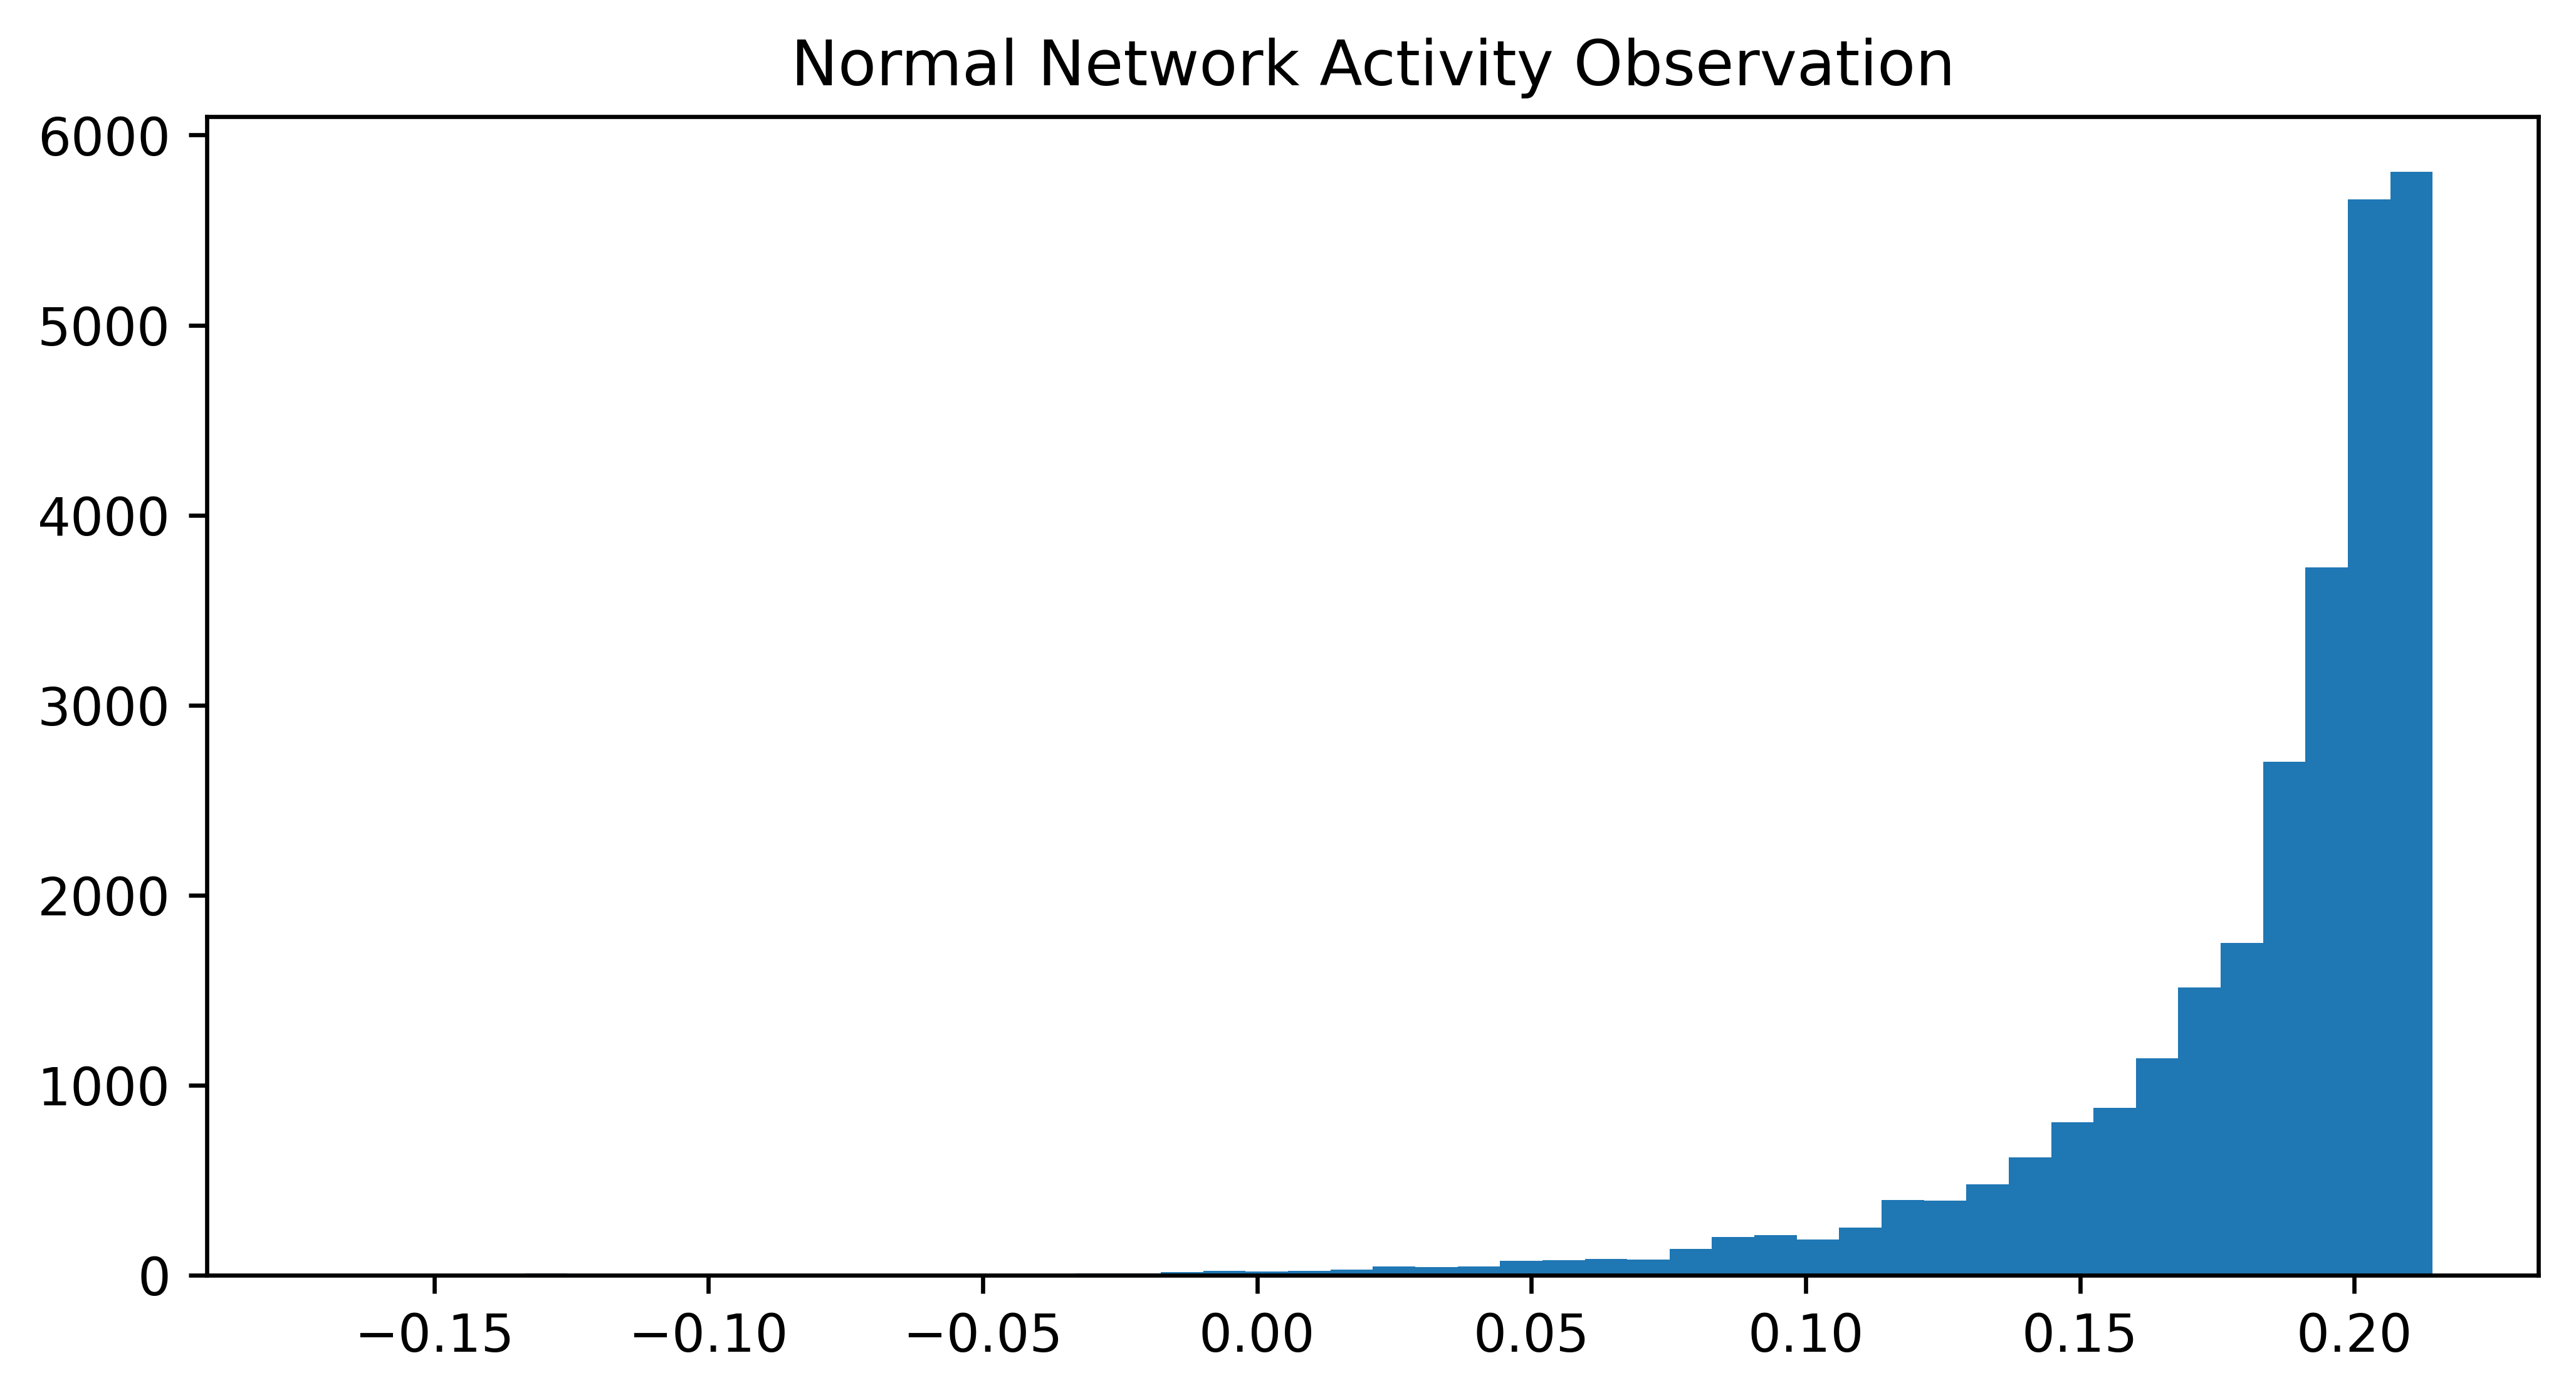

[0.20288989 0.18184593 0.18489796 ... 0.13370583 0.17228429 0.1840452 ]


In [97]:
#Plotting the various scores for a normal network
#Decisioin function score for Normal-Attack where Higher scores indicate normal points, lower scores indicate anomalies
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4), dpi=600, facecolor="w", edgecolor="k")
plt.hist(classifierScores_taffic_train_normal, bins=50)
plt.title("Normal Network Activity Observation")
plt.show()

print(classifierScores_taffic_train_normal)

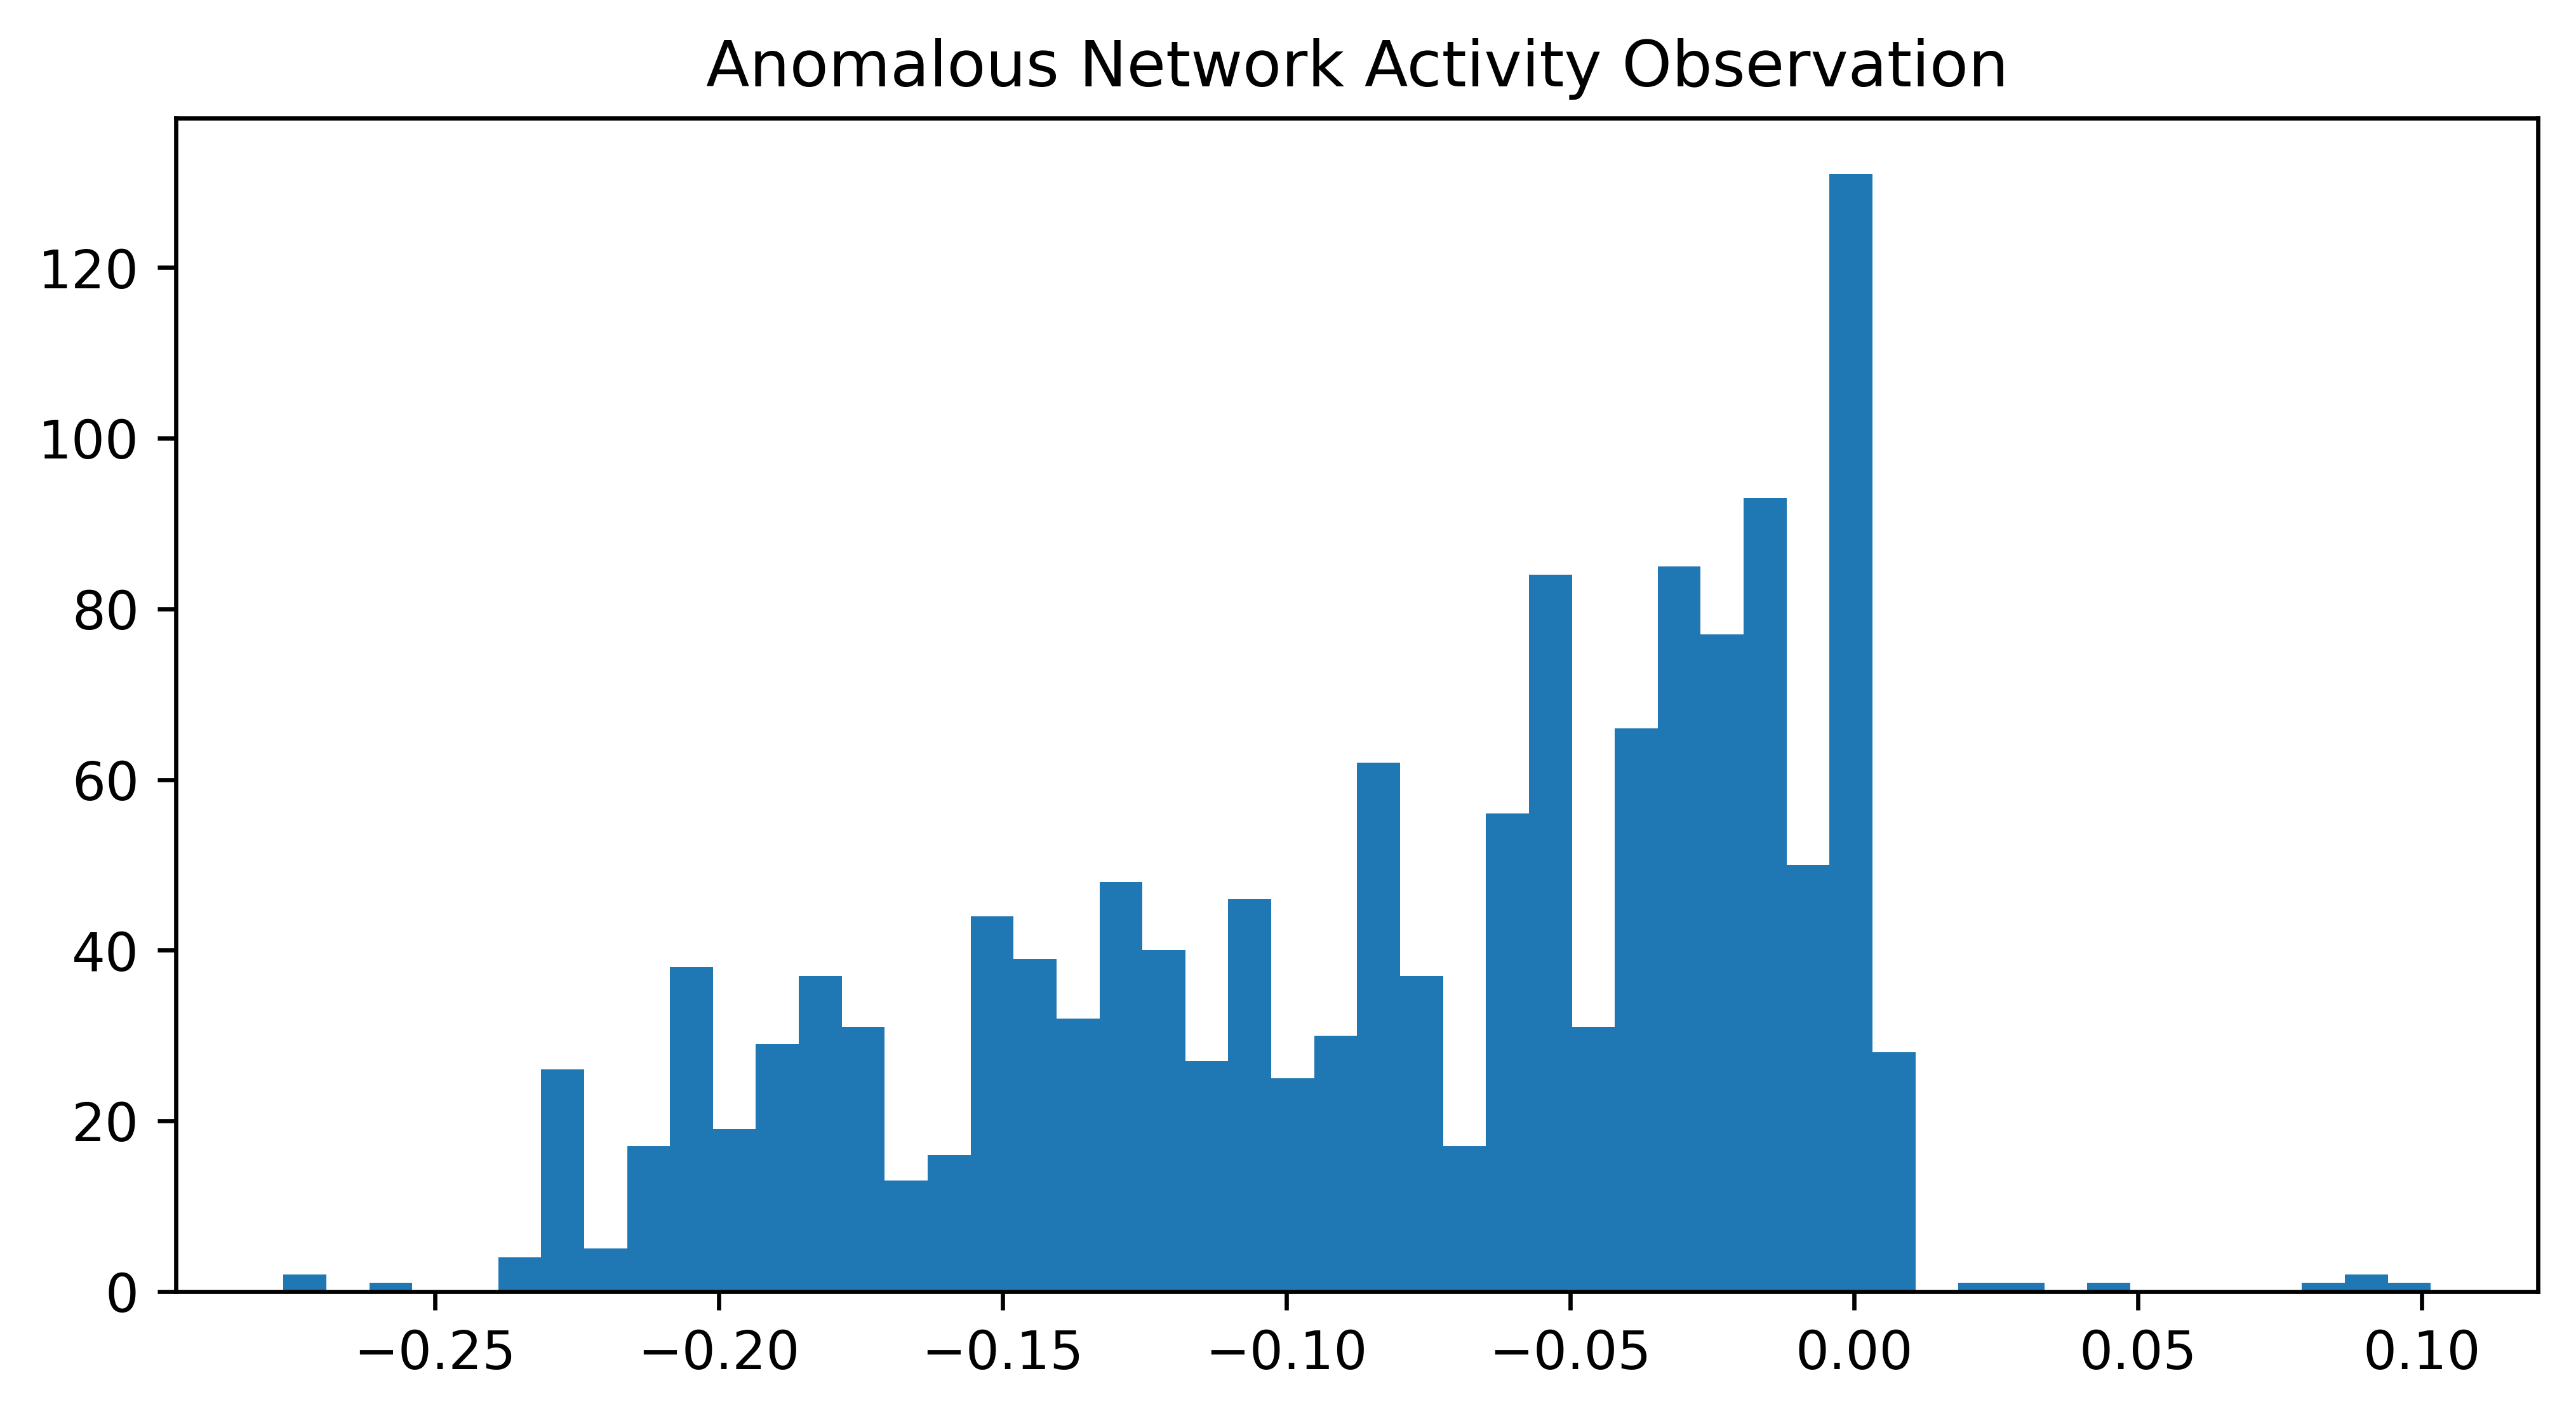

[ 0.00265087 -0.02597426 -0.03281179 ... -0.09080168  0.00585066
 -0.02597426]


In [99]:
#Plotting the various scores for an abnormal network
#Decisioin function score for Abnormal-Attack
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4), dpi=600, facecolor="w", edgecolor="k")
plt.hist(classifierScores_taffic_train_anomaly, bins=50)
plt.title("Anomalous Network Activity Observation")
plt.show()

print(classifierScores_taffic_train_anomaly)

In [101]:
cutoff = 0
print(Counter(y_test))
print(Counter(y_test[cutoff > isolationTrain.decision_function(X_test)]))

Counter({0: 11775, 1: 597})
Counter({1: 558, 0: 37})


In [141]:
#declaring various model scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report

#models accuracy score
y_pred = isolationTrain.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

Accuracy Score: 0.99


In [143]:
#precison score
precision = precision_score(y_test, y_pred)
print(f"Precision Score: {precision:.2f}")

Precision Score: 0.94


In [107]:
#F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.94


In [109]:
#recall Score
recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall:.2f}")

Recall Score: 0.93


Text(0, 0.5, 'Score')

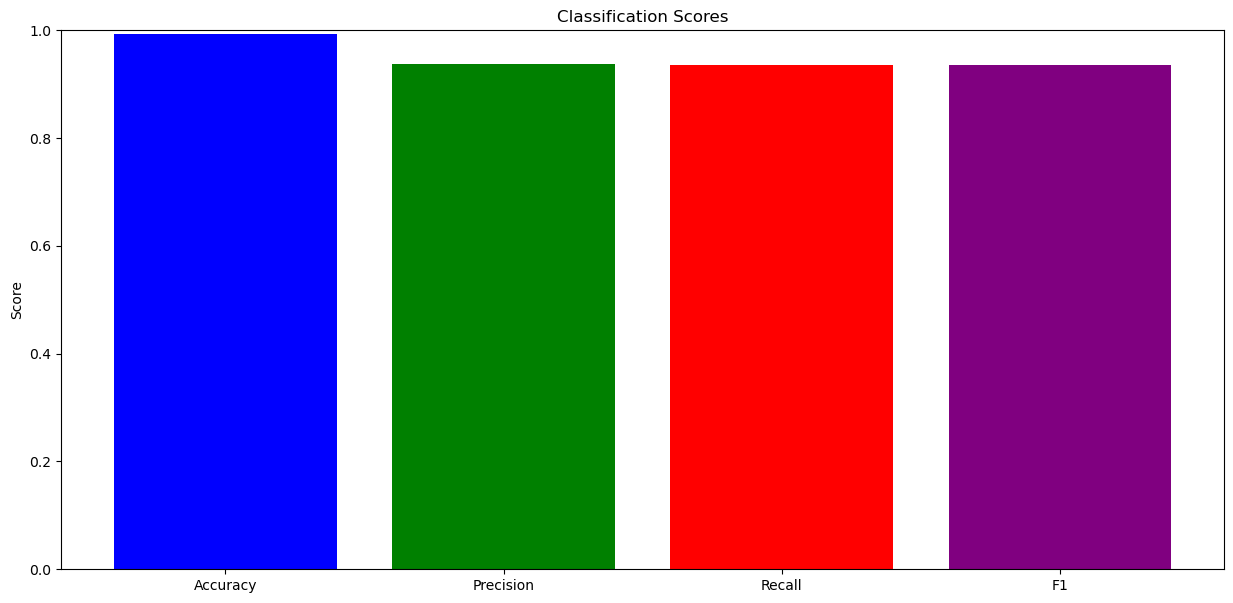

In [111]:
#plotting Accuracy, Precision, Recall, F1-score
plt.figure(figsize=(15, 7))
plt.bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1], color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Classification Scores')
plt.ylabel('Score')

In [113]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[11738    37]
 [   39   558]]


Text(50.72222222222221, 0.5, 'True Labels')

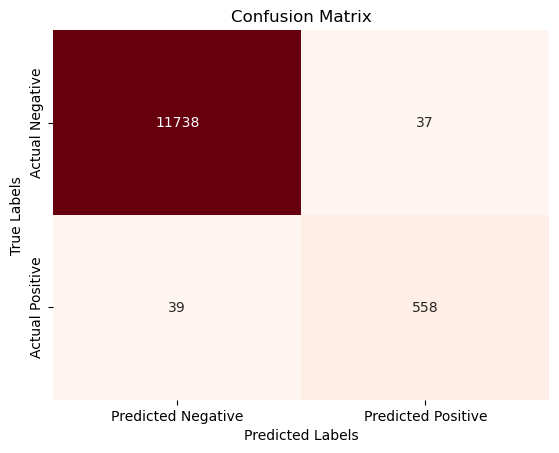

In [115]:
import seaborn as sns
#plotting confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [117]:
#ROC_AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc:.2f}")

ROC AUC: 0.97


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


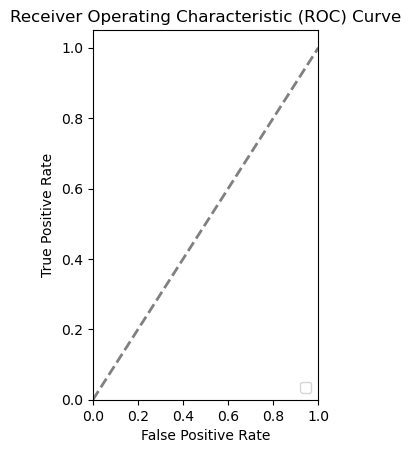

In [119]:
# Plotting ROC Curve
plt.subplot(1, 2, 2)
plt.plot(color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

In [121]:
# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11775
           1       0.94      0.93      0.94       597

    accuracy                           0.99     12372
   macro avg       0.97      0.97      0.97     12372
weighted avg       0.99      0.99      0.99     12372



We start by reading the KDD cup dataset into a data frame. Next, in Step 2, we examine our
data, to see that a majority of the traffic is normal, as expected, but a small amount is
abnormal. Evidently, the problem is highly imbalanced. Consequently, this problem is a
promising candidate for an anomaly detection approach. In Steps 3 and 5, we transform all
non-normal traffic into a single class, namely, anomalous.
We also make sure to compute the ratio of anomalies to normal observations (Step 4),
known as the contamination parameter. This is one of the parameters that facilitates setting
of the sensitivity of isolation forest. This is optional, but is likely to improve performance.
We split our dataset into normal and anomalous observations in Step 6, as well as split our
dataset into training and testing versions of the normal and anomalous data (Step 7). We
instantiate an isolation forest classifier, and set its contamination parameter (Step 8). The
default parameters, n_estimators and max_samples, are recommended in the paper
Isolation Forest by Liu et al. In Steps 9 and 10, we use the decision function of isolation forest
to provide a score to the normal training set, and then examine the results in a plot. In Step
11, we similarly provide a score to the anomalous training set.
Knowing that the decision function is a measure of how simple a point is to describe, we
would like to separate out simple points from complicated points by picking a numerical
cut-off that gives clear separation. A visual examination suggests the value chosen in Step
12.
Finally, we can use our model to make predictions and provide an assessment of its
performance. In Step 13, we see that the model was able to pick up on a large number of
anomalies without triggering too many false positives (instances of normal traffic),
speaking proportion-wise.